In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from importlib import reload
import matplotlib.pyplot as plt

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import resnet

from tensorboardX import SummaryWriter
%load_ext line_profiler

In [41]:
gmm = torch.load('SavedModels/GMM/gmm_MNIST_n1000_data_used60000_augm_flagTrue_alg_scikit.pth')

In [45]:
((gmm.logvar.exp()**.5).mean())

tensor(5.4173, grad_fn=<MeanBackward1>)

In [43]:
gmm.logvar.data += np.log(784)

In [46]:
torch.save(gmm, 'SavedModels/GMM/gmm_MNIST_n1000_data_used60000_augm_flagTrue_alg_scikit_scaledSTD_factor28.pth')

In [30]:
loaderE = dl.EMNIST(train=False, augm_flag=False)
e = enumerate(loaderE)
data = e.__next__()[1][0]
a = torch.logsumexp(gmm(data.view(-1,784)), 0)

In [23]:
name = 'model_gmmMNIST_lam-791.0_n1000_lr0.0001_augm_flagTrue_train_typeACETgrad_vars mu_customGMM.pth'
model = torch.load('SavedModels/'+name).to('cpu')

device = torch.device('cuda:6')
model.to(device)
loader = dl.MNIST(train=False, augm_flag=False)
a = tt.test(model.base_model, device, loader)
b = tt.test(model, device, loader)
print(a)
print(b)

(0.9904, 0.9812486883640289, 0.034394571808353064)
(0.9904, 0.9805830691337586, 0.0350477294921875)


In [21]:
name = 'base_model_MNIST.pth'
model = torch.load('SavedModels/'+name).to('cpu')

device = torch.device('cuda:6')
model.to(device)
loader = dl.MNIST(train=False, augm_flag=False)
b = tt.test(model, device, loader)
print(b)

(0.9898, 0.9882590006828308, 0.027768791818618774)


In [24]:
model_params = params.params_dict['MNIST'](augm_flag=True)
df = ev.evaluate(model, device, 'MNIST', model_params.loaders)

NameError: name 'hps' is not defined

In [25]:
df = ev.evaluate(model, device, 'MNIST', model_params.loaders)

In [47]:
%timeit -r 100 -n 1 model(data)

17.6 ms ± 4 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [4]:
reload(adv)
device = 'cuda:2'
base_model = resnet.ResNet18()
gmm = torch.load('SavedModels/GMM/gmm_CIFAR10_n1000_data_used50000_augm_flagTrue_alg_scikit.pth')
model = models.RobustModel(base_model, gmm, 900., dim=3072).to(device)
loaderE = dl.CIFAR10(train=False, batch_size=128, augm_flag=False)
e = enumerate(loaderE)
data = e.__next__()[1][0].to(device)

In [194]:
def test():
    for _ in range(40):
        y = model(data)
        y.sum().backward()
    #adv.gen_adv_noise(model, device, data, steps = 3)

In [192]:
for _ in range(1):
    %lprun -f test test()

In [184]:
for _ in range(100):
    %lprun -f model.forward model.forward(data)

In [5]:
for _ in range(1):
    %lprun -f adv.gen_adv_noise adv.gen_adv_noise(base_model, device, data, steps = 40)

In [138]:
torch._C._VariableFunctions.norm

<function _VariableFunctions.norm>

In [99]:
gmm = models.GMM(K = 1000, D = 3072, mu = gmm.mu, logvar = gmm.logvar, alpha=gmm.alpha)

In [195]:
torch._C._VariableFunctions.norm

<module 'resnet' from '/home/alexm/project/notebooks/gmm-robust/resnet.py'>

In [196]:
m = resnet.ResNet18().to(device)

In [197]:
m(data)

tensor([[ 0.2940,  0.4537, -0.7690,  ..., -0.4613,  0.0983,  0.4904],
        [ 1.2166,  0.3336, -0.0556,  ..., -0.0972, -0.9780, -0.6149],
        [ 0.1117,  1.1222,  0.7020,  ..., -0.1378,  0.2008, -0.3253],
        ...,
        [ 0.0535,  0.5629, -0.5316,  ..., -0.1256,  0.7781, -0.0677],
        [-0.2896,  1.0484,  0.5866,  ..., -0.5581, -0.7391, -0.3642],
        [-0.1760,  0.8297,  0.5402,  ..., -0.5511, -0.6035,  0.0030]],
       device='cuda:1', grad_fn=<AddmmBackward>)

In [182]:
for _ in range(300):
    %lprun -f m.forward m.forward(data)

In [205]:
import torch

In [2]:
device = torch.device('cuda:3')
base_model = torch.load('SavedModels/model_baseCIFAR10_lr0.1_augm_flagTrue_train_typeplain.pth').to(device)

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


tensor([0.9789, 0.4076, 0.9549, 0.4320, 0.8757, 0.9258, 0.6497, 0.9461, 0.5638,
        0.7560], device='cuda:3', grad_fn=<ExpBackward>)

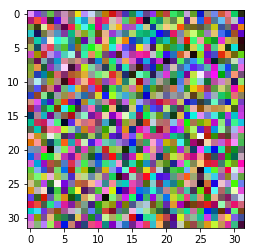

In [4]:
plt.imshow(x[5].detach().cpu().transpose(0,2))

In [60]:
x = torch.rand(1,3,32,32,device=device)
base_model(x).max(1)[0].exp()
noise = adv.gen_adv_noise(base_model, device, x, epsilon=.3, steps=10, step_size=0.01)
F.log_softmax(logits(base_model, noise)[:,:10]/5 , dim=1).exp().max(1)

(tensor([0.7309], device='cuda:3', grad_fn=<MaxBackward0>),
 tensor([2], device='cuda:3'))

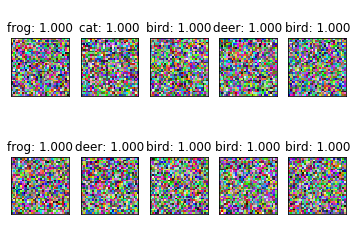

In [6]:
y = base_model(noise)
plotting.plot_samples([y], noise.detach().cpu(), dataset='CIFAR10')

In [7]:
def logits(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

(tensor([0.7487, 0.4003, 0.5828, 0.6995, 0.7426, 0.7409, 0.7399, 0.7677, 0.5360,
         0.7351], device='cuda:3', grad_fn=<MaxBackward0>),
 tensor([6, 3, 1, 4, 2, 6, 4, 2, 9, 2], device='cuda:3'))

In [8]:
loader = dl.CIFAR10(train=False, augm_flag=False)

In [123]:
x =1-.01*torch.rand(100,3,32,32,device=device)
base_model(x).max(1)[0].exp()
noise = adv.gen_adv_noise(base_model, device, x, epsilon=.3, steps=40, step_size=0.01)
F.log_softmax(logits(base_model, noise)[:,:10]/5 , dim=1).exp().max(1)

(tensor([0.5790, 0.5974, 0.6431, 0.1898, 0.7015, 0.1616, 0.4471, 0.5759, 0.4575,
         0.6015, 0.4343, 0.3530, 0.3832, 0.6050, 0.5983, 0.4933, 0.6220, 0.6857,
         0.6191, 0.4179, 0.6072, 0.5986, 0.7018, 0.2838, 0.6041, 0.3493, 0.4934,
         0.5857, 0.2803, 0.7104, 0.5801, 0.4053, 0.4188, 0.4542, 0.6276, 0.2864,
         0.6138, 0.5948, 0.6089, 0.2826, 0.5802, 0.6258, 0.5739, 0.5921, 0.6243,
         0.1519, 0.6149, 0.6085, 0.6825, 0.6963, 0.6126, 0.6172, 0.4277, 0.6051,
         0.5995, 0.4352, 0.5913, 0.6168, 0.5554, 0.2813, 0.4482, 0.6317, 0.6222,
         0.6202, 0.6008, 0.4094, 0.4165, 0.6225, 0.6147, 0.4007, 0.6063, 0.6010,
         0.5977, 0.2141, 0.5946, 0.4286, 0.5978, 0.6174, 0.6245, 0.6136, 0.5998,
         0.5894, 0.4275, 0.2894, 0.4010, 0.6089, 0.6202, 0.2803, 0.4295, 0.6844,
         0.5970, 0.4219, 0.1581, 0.6225, 0.4291, 0.6256, 0.1603, 0.5687, 0.4251,
         0.7021], device='cuda:3', grad_fn=<MaxBackward0>),
 tensor([8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 5, 8, 8

In [125]:

T = 10.
m = []
for _, (a,_) in enumerate(loader):
    a = adv.gen_adv_noise(base_model, device, a, epsilon=.3, steps=1, step_size=0.01)
    m.append( F.log_softmax(logits(base_model, a.to(device))[:,:10]/T , dim=1).max(1)[0])
m = torch.cat(m, 0)
a = []
for p in noise:
    c = F.log_softmax(logits(base_model, p.unsqueeze(0))[:,:10]/T , dim=1).max().item()
    a.append( ( (m<c).sum().float()/10000. ).item())
a = np.array(a)

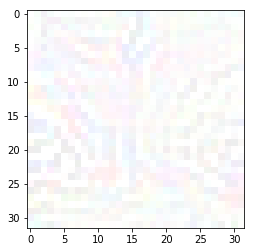

In [124]:
plt.imshow(noise[0].permute((1,2,0)).detach().cpu())

In [77]:
for p in noise:
    temp = logits(base_model, p.unsqueeze(0))[:,:10]/T
    c = F.log_softmax(temp , dim=1).max().item()

In [129]:
base_model = torch.load('Checkpoints/base_CIFAR10_lr0.1_augm_flagTrue_train_typeplain.pth').to(device)

In [133]:
x = torch.rand(10,3,32,32,device=device)
base_model(x).max(1)[0].exp()
noise = adv.gen_adv_noise(base_model, device, x, epsilon=.3, steps=10, step_size=0.01)
F.log_softmax(logits(base_model, noise) , dim=1).exp().max(1)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000], device='cuda:3', grad_fn=<MaxBackward0>),
 tensor([6, 6, 6, 6, 6, 6, 6, 2, 2, 6], device='cuda:3'))

In [135]:
base_model(x).max(1)[0].exp()

tensor([0.9877, 0.9790, 0.9918, 0.9599, 0.9858, 0.9888, 0.9947, 0.9534, 0.9928,
        0.9924], device='cuda:3', grad_fn=<ExpBackward>)